### Пайплан 
1. Предобработка
2. обучение модели, 
3. создание эмбеддингов с помощью FastText,
4. определение оптимального количетва кластеров методом локтя, 
5. кластеризация, 
6. выделение топ слов в каждом кластере, 
7. тестрование точности определения ключевых слов.

In [1]:
import pandas as pd
import numpy as np
import pymorphy2
import re

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import preprocessing

from nltk.probability import FreqDist

from gensim.models import FastText
from matplotlib import pyplot
from itertools import chain
from tqdm import tqdm

## загрузка стопслов

In [2]:
with open('stopwords-ru.txt', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

stopwords.append('%')
stopwords.append('num')
stopwords.append('d_')
stopwords.append('x')

In [3]:
df = pd.read_csv('news.csv', sep=',', encoding='utf-8')
df = df[~df.text.isna()]
df.head()

,source,title,text,publication_date,rubric,subrubric,tags
0,lenta.ru,Синий богатырь,В 1930-е годы Советский Союз охватила лихорадк...,2020-08-30T00:01:00+03:00,Экономика,Госэкономика,NaN
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,Олимпийская чемпионка по фигурному катанию Ал...,2020-08-31T20:04:00+03:00,Спорт,Зимние виды,NaN
2,lenta.ru,Объяснена опасность однообразного питания,Российский врач-диетолог Римма Мойсенко объясн...,2020-08-31T20:07:00+03:00,Из жизни,Еда,NaN
3,lenta.ru,«Предохраняться? А зачем?»,В 2019 году телеканал «Ю» запустил адаптацию з...,2020-08-30T00:04:00+03:00,Интернет и СМИ,ТВ и радио,NaN
4,lenta.ru,Ефремов систематически употреблял наркотики,Актер Михаил Ефремов систематически употребл...,2020-08-31T18:27:00+03:00,Культура,Кино,NaN


In [4]:
def clean_text(text):
    text = text.lower()
    regular = r'[^a-zа-яё]+'
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    text = re.sub(regular, ' ', text)
    text = re.sub(regular_url, r'URL', text)
    text = re.sub(r'(\d+\s\d+)|(\d+)',' num ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def delete_stopwords(string):
    tokens = string.split()
    tokens_res = []
    for i in tokens:
        if i not in stopwords:
            tokens_res.append(i)
    return ' '.join(tokens_res)

def check_list(list_):
    if list_:
        return True
    else: return False

## предобработка

In [5]:
df['text'] = df['text'].apply(lambda x: delete_stopwords(clean_text(x)))

In [6]:
morph = pymorphy2.MorphAnalyzer()

sentences = df['text'].to_list()

In [7]:
%%time
sentences_tok = []

for sent in sentences:
    tokens_sent = sent.lower().split()
#     tokens_sent = [short_dict.get(x,x) for x in tokens_sent]
    tokens_sent = delete_stopwords(clean_text(' '.join(tokens_sent))).split()
    tokens_sent = [word for word in tokens_sent if len(word) > 3]
    tokens = list([morph.parse(_)[0].normal_form for _ in tokens_sent])
    sentences_tok.append(tokens)
    
df['text_tok'] = sentences_tok
df = df[df.apply(lambda x: check_list(x['text_tok']), axis=1)]

Wall time: 11min 44s


In [8]:
df.head()

,source,title,text,publication_date,rubric,subrubric,tags,text_tok
0,lenta.ru,Синий богатырь,годы советский союз охватила лихорадка десятил...,2020-08-30T00:01:00+03:00,Экономика,Госэкономика,NaN,"[год, советский, союз, охватить, лихорадка, де..."
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,олимпийская чемпионка фигурному катанию алина ...,2020-08-31T20:04:00+03:00,Спорт,Зимние виды,NaN,"[олимпийский, чемпионка, фигурный, катание, ал..."
2,lenta.ru,Объяснена опасность однообразного питания,российский врач диетолог римма мойсенко объясн...,2020-08-31T20:07:00+03:00,Из жизни,Еда,NaN,"[российский, врач, диетолог, римма, мойсенко, ..."
3,lenta.ru,«Предохраняться? А зачем?»,телеканал ю запустил адаптацию знаменитого тел...,2020-08-30T00:04:00+03:00,Интернет и СМИ,ТВ и радио,NaN,"[телеканал, запустить, адаптация, знаменитый, ..."
4,lenta.ru,Ефремов систематически употреблял наркотики,актер михаил ефремов систематически употреблял...,2020-08-31T18:27:00+03:00,Культура,Кино,NaN,"[актёр, михаил, ефрем, систематически, употреб..."


In [9]:
def check_len(tokens):
    tokens_cleaned = []
    for i in tokens:
        if len(i) >= 3:
            tokens_cleaned.append(i)
    return tokens_cleaned

In [10]:
df.text_tok = df.text_tok.apply(lambda x: check_len(x))
df = df.drop_duplicates(subset='text')

## обучение FastText

In [11]:
df = df[df.text_tok.apply(lambda x: (len(x) > 2))]

In [12]:
df_orign = df.copy()

df = df.head(5000)
df.shape

(5000, 8)

In [13]:
model = FastText(vector_size=300, window=5, min_count=2)
model.build_vocab(corpus_iterable=df.text_tok.to_list())
model.train(corpus_iterable=df.text_tok.to_list(), total_examples=len(df.text_tok.to_list()), epochs=10)

(6075228, 6301690)

In [14]:
model.wv.most_similar('продук')

[('продукт', 0.9649566411972046),
 ('продажа', 0.9047145247459412),
 ('продавец', 0.8981866240501404),
 ('пробежка', 0.8883215188980103),
 ('прокачка', 0.8853464722633362),
 ('продавщица', 0.882567822933197),
 ('приморнефтепродукт', 0.8743192553520203),
 ('просрочка', 0.8706531524658203),
 ('продуктовый', 0.8704662919044495),
 ('произвол', 0.8660559058189392)]

In [15]:
model.save('news.model')

## загрузка обученной модели

In [16]:
model = FastText.load('news.model')

In [17]:
def word_embadding_fasttext(word):
    res = model.wv.get_vector(word)
    if res is None: return np.zeros(300)
    else: return res

def sentence_embadding_fasttext(sent):
    embedding = [word_embadding_fasttext(x) for x in sent]   
    embedding = np.mean(embedding, axis=0)
    return embedding

In [18]:
sent_emb = [sentence_embadding_fasttext(sent) for sent in df.text_tok]

### определение оптимального количества кластеров

100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


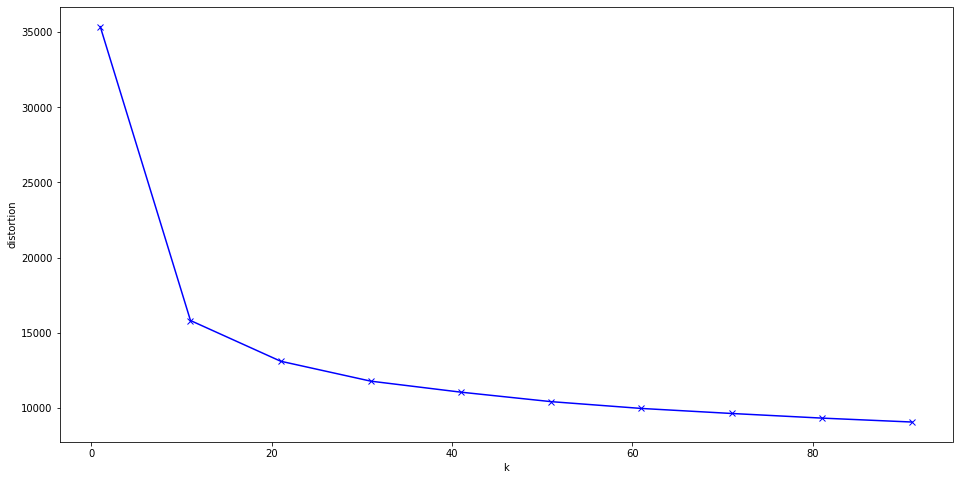

In [19]:
K_n = range(1, 100, 10)

distortions = []

for k in tqdm(K_n):
    kmeans = KMeans(n_clusters=k).fit(sent_emb)
    distortions.append(kmeans.inertia_)

pyplot.figure(figsize=(16,8))
pyplot.plot(K_n, distortions, 'bx-')
pyplot.xlabel('k')
pyplot.ylabel('distortion')
pyplot.show()

### кластеризация

In [20]:
kmeans = KMeans(n_clusters=15).fit(sent_emb)

In [21]:
pca = PCA(n_components=2)
result = pca.fit_transform(sent_emb)

x = [x[0] for x in result] 
y = [y[1] for y in result] 

df['x'] = x
df['y'] = y

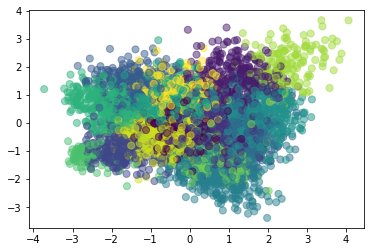

In [22]:
pyplot.scatter(df['x'], df['y'], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
pyplot.show()

In [23]:
df['label'] = kmeans.labels_

In [24]:
pd.DataFrame(list(chain.from_iterable(df[df.label == 7].text_tok.to_list()))).value_counts().head()

коронавирус    886
россия         508
страна         454
человек        379
москва         327
dtype: int64

# test

In [25]:
test_orign = 'военные на границе с россией выставили вооружения'

In [26]:
# предобработка текста

test = delete_stopwords(clean_text(test_orign))
test

'военные границе россией выставили вооружения'

In [27]:
# получение эмбединга текста

test_emb = sentence_embadding_fasttext([test])
test_emb[:4]

array([ 0.00619834,  0.08600322, -0.2625694 ,  0.10302448], dtype=float32)

In [28]:
# определение кластера

claster = kmeans.predict([test_emb])[0]
claster

11

In [29]:
# вывод топ 5 наиболее частых слов в кластере

fdist = FreqDist(list(chain.from_iterable(df[df.label == claster].text_tok.to_list())))
words_uniq_claster = [i[0] for i in fdist.most_common(5)]
words_uniq_claster

['военный', 'россия', 'страна', 'российский', 'заявить']